In [2]:
%matplotlib inline 


from nltk.collocations import *

from gensim.models import word2vec

import pandas as pd
from collections import Counter
import functools
import tqdm
import re
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from itertools import product

from __future__ import division

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import nltk, string
from nltk.tokenize import punkt
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords

from pymorphy2 import MorphAnalyzer
import pymorphy2


import xgboost as xgb
from xgboost import XGBClassifier

import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import  roc_auc_score

import matplotlib.pyplot as plt
from hyperopt import hp, tpe, STATUS_OK, Trials, rand
from hyperopt import fmin as fminHyper

from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
exclude = set(punctuation + u'0123456789[]—«»–')
from pymorphy2 import MorphAnalyzer

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns', 100)

## Загрузим даные

In [141]:
dftrain = pd.read_csv('../data/train_task1_latest_pred.csv', sep=';')
dftest = pd.read_csv('../data/test_task1_latest_pred.csv', sep=';')

## Xgb all the things

In [123]:
dftrain.head(1)

,generated_p,generated_p_2,generated_p_3,paragraph,paragraph_id,question,question_id,target,len_paragraph,len_question,len_intersection,idf_question,idf_paragraph,idf_intersection,relative_question_len,relative_intersection_len,relative_intersection_question_len,relative_question_idf,relative_intersection_idf,relative_intersection_question_idf,word_idf_paragraph,word_idf_question,word_idf_intersection,paragraph_lemmatized,question_lemmatized,word2vec_similarity_max,word2vec_similarity_min,word2vec_similarity_mean,word2vec_similarity_std,len_intersection_w2v,idf_intersection_w2v,relative_intersection_len_w2v,relative_intersection_question_len_w2v,relative_intersection_idf_w2v,relative_intersection_question_idf_w2v,word_idf_intersection_w2v,word_mover_distance,word_mover_distance_lemm,word_mover_sentence_distance_mean,word_mover_sentence_distance_std,word_mover_sentence_distance_max,word_mover_sentence_distance_min,word_mover_sentence_distance_split_max,word_mover_sentence_distance_split_min,word_mover_sentence_distance_split_mean,word_mover_sentence_distance_split_std,word_mover_sentence_distance_split_lemm_max,word_mover_sentence_distance_split_lemm_min,word_mover_sentence_distance_split_lemm_mean,word_mover_sentence_distance_split_lemm_std,len_overlap_relative_paragraph_max,len_overlap_relative_question_max,idf_overlap_max,len_overlap_relative_paragraph_mean,len_overlap_relative_question_mean,idf_overlap_mean,len_overlap_relative_paragraph_std,len_overlap_relative_question_std,idf_overlap_std,len_overlap_relative_paragraph_max_w2v,len_overlap_relative_question_max_w2v,idf_overlap_max_w2v,len_overlap_relative_paragraph_mean_w2v,len_overlap_relative_question_mean_w2v,idf_overlap_mean_w2v,len_overlap_relative_paragraph_std_w2v,len_overlap_relative_question_std_w2v,idf_overlap_std_w2v,similarity_tfid,similarity_tfid_split_max,similarity_tfid_split_min,similarity_tfid_split_mean,similarity_tfid_split_std,similarity_pattern_mean,similarity_pattern_std,similarity_pattern_max,similarity_pattern_min,unique_words_relative_to_question,word_ocurences_mean,word_ocurences_std,word_ocurences_max,word_ocurences_max_relative_to_question,grammar_prediction
0,0.0,0.0,0.0,"В отличие от рыб, земноводные (амфибии) и прес...",1094,С какого года Русское Царство перешло на летои...,46273.0,0.0,67.0,19.0,3.0,105.9203,469.511514,6.152327,0.283582,0.044776,0.157895,0.225597,0.013104,0.058084,7.007635,5.574753,2.050776,отличие рыба земноводный амфибия пресмыкаться ...,какой год русский царство перейти летоисчислен...,0.0,0.0,0.0,0.0,2211.0,5662.783398,33.0,116.368421,12.061011,53.462683,1887.594466,1.39325,0.959353,1.649956,0.159096,1.824309,1.436376,2.189363,1.907166,2.033987,0.116963,2.165799,2.043947,2.085213,0.056988,0.004292,0.022901,5.346128,0.002504,0.013359,2.784076,0.001186,0.006329,1.827011,0.058655,0.312977,53.691968,0.04578,0.244275,35.560142,0.012876,0.068702,15.582323,0.0,0.0,0.0,0.0,0.0,0.048449,0.076627,0.173041,0.0,1.315789,1.153846,0.360801,2.0,0.105263,0.000558


In [124]:
columns = ['len_paragraph', 'len_question', 'len_intersection', 'idf_question', 'idf_paragraph', 'idf_intersection', 'relative_question_len', 'relative_intersection_len', 'relative_intersection_question_len', 'relative_question_idf', 'relative_intersection_idf', 'relative_intersection_question_idf', 'word_idf_paragraph', 'word_idf_question', 'word_idf_intersection', 'word2vec_similarity_max', 'word2vec_similarity_min', 'word2vec_similarity_mean', 'word2vec_similarity_std', 'len_intersection_w2v', 'idf_intersection_w2v', 'relative_intersection_len_w2v', 'relative_intersection_question_len_w2v', 'relative_intersection_idf_w2v', 'relative_intersection_question_idf_w2v', 'word_idf_intersection_w2v', 'word_mover_distance', 'word_mover_distance_lemm', 'word_mover_sentence_distance_mean', 'word_mover_sentence_distance_std', 'word_mover_sentence_distance_max', 'word_mover_sentence_distance_min', 'word_mover_sentence_distance_split_max', 'word_mover_sentence_distance_split_min', 'word_mover_sentence_distance_split_mean', 'word_mover_sentence_distance_split_std', 'word_mover_sentence_distance_split_lemm_max', 'word_mover_sentence_distance_split_lemm_min', 'word_mover_sentence_distance_split_lemm_mean', 'word_mover_sentence_distance_split_lemm_std', 'len_overlap_relative_paragraph_max', 'len_overlap_relative_question_max', 'idf_overlap_max', 'len_overlap_relative_paragraph_mean', 'len_overlap_relative_question_mean', 'idf_overlap_mean', 'len_overlap_relative_paragraph_std', 'len_overlap_relative_question_std', 'idf_overlap_std', 'len_overlap_relative_paragraph_max_w2v', 'len_overlap_relative_question_max_w2v', 'idf_overlap_max_w2v', 'len_overlap_relative_paragraph_mean_w2v', 'len_overlap_relative_question_mean_w2v', 'idf_overlap_mean_w2v', 'len_overlap_relative_paragraph_std_w2v', 'len_overlap_relative_question_std_w2v', 'idf_overlap_std_w2v', 'similarity_tfid', 'similarity_tfid_split_max', 'similarity_tfid_split_min', 'similarity_tfid_split_mean', 'similarity_tfid_split_std', 'similarity_pattern_mean', 'similarity_pattern_std', 'similarity_pattern_max', 'similarity_pattern_min', 'unique_words_relative_to_question', 'word_ocurences_mean', 'word_ocurences_std', 'word_ocurences_max', 'word_ocurences_max_relative_to_question', 'grammar_prediction']

In [125]:
# dftrain = dftrain[dftrain.generated_p == 0]
# dftrain = dftrain[dftrain.generated_p_2 == 0]

In [142]:
dftrain = dftrain.replace([np.inf, -np.inf], np.nan)
dftrain.fillna(0, inplace = True)

test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(dftrain[columns], dftrain['target'], test_size = test_size, random_state = random_state)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [143]:
def score(params):
    print("Training with params:")
    print(params)
    
    num_round = int(params['n_estimators'])    
    del params['n_estimators']
    params['max_depth'] = (int) (params['max_depth'])
    
    model = xgb.train(params, dtrain, num_round)
    
    predictions = model.predict(dvalid)
    score = roc_auc_score(y_test, predictions)
    
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [144]:
def optimize(trials):

    space = {
        'n_estimators' : 150,
        'eta' : hp.quniform('eta', 0.1, 0.5, 0.1),
        'max_depth' : hp.quniform('max_depth', 4, 10, 2),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
        'subsample' : hp.quniform('subsample', 0.5, 1, 0.25),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.25),
#         'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5, 1, 0.25),
#         'reg_alpha' : hp.quniform('reg_alpha', 0, 1, 0.5),
#         'reg_lambda' : hp.quniform('reg_lambda', 0, 1, 0.5),
        'eval_metric': 'auc',
        'objective': 'binary:logistic', 
        'nthread' : 4,
        'silent' : 1
    }
    
    best = fminHyper(score, space, algo=tpe.suggest, trials=trials, max_evals=75)
    print(best)

In [145]:
%%time
trials = Trials()
optimize(trials)

Training with params:
{'max_depth': 8.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.30000000000000004, 'colsample_bytree': 0.75, 'nthread': 4, 'min_child_weight': 4.0, 'subsample': 1.0}
	Score 0.9633067512345337


Training with params:
{'max_depth': 6.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.30000000000000004, 'colsample_bytree': 0.5, 'nthread': 4, 'min_child_weight': 2.0, 'subsample': 0.75}
	Score 0.9638360203953841


Training with params:
{'max_depth': 8.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.4, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 3.0, 'subsample': 0.75}
	Score 0.9602567483204121


Training with params:
{'max_depth': 8.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 4.0, 'subsam

	Score 0.9553175812042771


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 0.75, 'nthread': 4, 'min_child_weight': 1.0, 'subsample': 0.5}
	Score 0.9555974617131957


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 2.0, 'subsample': 0.5}
	Score 0.9552429439493766


Training with params:
{'max_depth': 8.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.4, 'colsample_bytree': 0.75, 'nthread': 4, 'min_child_weight': 3.0, 'subsample': 0.5}
	Score 0.9578972963624035


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 2.0, 'subsampl

	Score 0.9552429439493766


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 2.0, 'subsample': 0.5}
	Score 0.9552429439493766


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 1.0, 'subsample': 0.5}
	Score 0.9548610047986573


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 1.0, 'subsample': 0.5}
	Score 0.9548610047986573


Training with params:
{'max_depth': 10.0, 'n_estimators': 150, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'silent': 1, 'eta': 0.5, 'colsample_bytree': 1.0, 'nthread': 4, 'min_child_weight': 1.0, 'subsample

In [147]:
params = {'colsample_bytree': 1.0, 'max_depth': 10.0, 'min_child_weight': 1.0, 'subsample': 0.5, 'eta': 0.5}
params['objective'] = 'binary:logistic'
# params['eta'] = 0.1
params['max_depth'] = int(params['max_depth'])
params['eval_metric'] = 'auc'

**Смотрим на точность**

In [148]:
# прогоняем на кросс-валидации с метрикой merror
trees = 1000
cv = xgb.cv(params, dtrain, metrics = ('auc'), nfold = 5, num_boost_round=trees, early_stopping_rounds = 15, verbose_eval=True)

[0]	train-auc:0.965246+0.000577661	test-auc:0.956464+0.00217552
[1]	train-auc:0.97039+0.000634373	test-auc:0.959659+0.00177108
[2]	train-auc:0.973132+0.000430729	test-auc:0.960937+0.00184264
[3]	train-auc:0.975013+0.000586517	test-auc:0.961755+0.0016322
[4]	train-auc:0.976544+0.000607686	test-auc:0.962485+0.00153787
[5]	train-auc:0.977534+0.000657593	test-auc:0.962568+0.00159148
[6]	train-auc:0.978512+0.000759601	test-auc:0.963088+0.00143731
[7]	train-auc:0.979329+0.000755053	test-auc:0.963242+0.00140143
[8]	train-auc:0.979963+0.000611851	test-auc:0.963309+0.00132041
[9]	train-auc:0.980752+0.000506961	test-auc:0.96334+0.00130169
[10]	train-auc:0.981657+0.000337673	test-auc:0.963098+0.00121941
[11]	train-auc:0.982553+0.000422261	test-auc:0.962787+0.00121369
[12]	train-auc:0.983343+0.00046025	test-auc:0.962555+0.00133434
[13]	train-auc:0.984474+0.000661763	test-auc:0.962258+0.00126081
[14]	train-auc:0.985356+0.000489749	test-auc:0.961969+0.00111885
[15]	train-auc:0.986076+0.000303277	tes

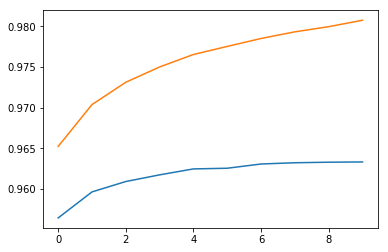

In [149]:
plt.plot(range(cv.shape[0]), cv['test-auc-mean'])
plt.plot(range(cv.shape[0]), cv['train-auc-mean'])

In [150]:
num_boost_round=cv['test-auc-mean'].argmax()
bst = xgb.train(params, dtrain, num_boost_round=num_boost_round)

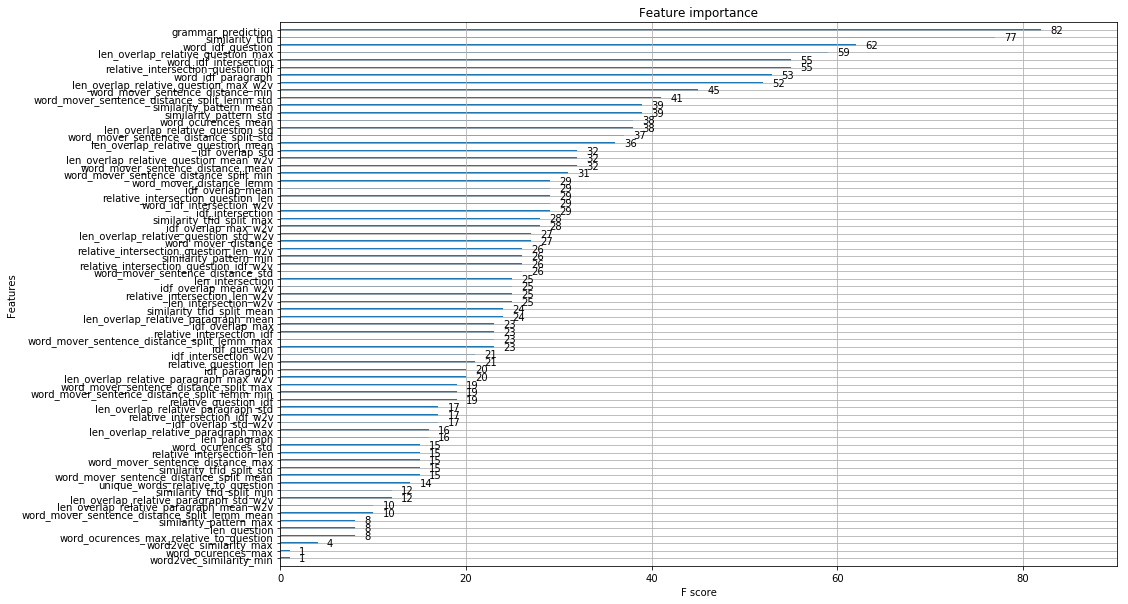

In [151]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(booster=bst, ax=ax)

In [152]:
xpredictions = bst.predict(dvalid)
score = roc_auc_score(dvalid.get_label(), xpredictions)
print('xgb - roc_auc_score: ' + str(score))

xgb - roc_auc_score: 0.963048078911


In [153]:
a = []
for i in range(0, 3):
    params_i = params
    params_i['colsample_bylevel'] = 0.5 + i * 0.25
    params_i['colsample_bytree'] = 0.5 + i * 0.25
    a.append(xgb.train(params_i, dtrain, num_boost_round=num_boost_round).predict(dvalid))

In [154]:
data = a
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)
print('e - roc_auc_score: ' + str(score))

e - roc_auc_score: 0.966006620706


In [155]:
xpredictions = epredictions

**random forest classifier**

In [113]:
regr = RandomForestClassifier(n_estimators=500, random_state=random_state, n_jobs=4)
regr.fit(X_train, y_train)

rfcpredictions= regr.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, rfcpredictions)
print('rfr - roc_auc_score: ' + str(score))
                              
data = [rfcpredictions, xpredictions]
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)
print('e - roc_auc_score: ' + str(score))

rfr - roc_auc_score: 0.996690711735
e - roc_auc_score: 0.997167721874


**xgb classifier**

In [114]:
xgb_c = XGBClassifier()
xgb_c.fit(X_train, y_train)

xgb_c_predictions= xgb_c.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, xgb_c_predictions)
print('xgbc - roc_auc_score: ' + str(score))

data = [xgb_c_predictions, xpredictions]
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)

print('e - roc_auc_score: ' + str(score))

xgbc - roc_auc_score: 0.99664941129
e - roc_auc_score: 0.997163690899


**linear regression**

In [115]:
xgb_c = XGBRegressor(objective = 'reg:linear')
xgb_c.fit(X_train, y_train)
xgb_l_predictions= xgb_c.predict(X_test)

score = roc_auc_score(y_test, xgb_l_predictions)
print('xgbr - roc_auc_score: ' + str(score))

data = [xpredictions, xgb_l_predictions]
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)

print('e - roc_auc_score: ' + str(score))

xgbr - roc_auc_score: 0.99554778134
e - roc_auc_score: 0.996691942733


**n2gether now**

In [116]:
data = [xpredictions, xgb_c_predictions, xgb_l_predictions, rfcpredictions]
epredictions = [sum(e)/len(e) for e in zip(*data)]
score = roc_auc_score(y_test, epredictions)

print('e - roc_auc_score: ' + str(score))

e - roc_auc_score: 0.996910781293


## Обучим на всех данных

In [156]:
# полные данные
dtrainfull = xgb.DMatrix(dftrain[columns], dftrain['target'])

# прогоняем на кросс-валидации с метрикой merror
trees = 1000
cv = xgb.cv(params, dtrainfull, metrics = ('auc'), nfold=5, num_boost_round=trees, early_stopping_rounds=50, verbose_eval=False)

In [157]:
# triple xgb
a = []
for i in range(0, 3):
    params_i = params
    params_i['colsample_bylevel'] = 0.5 + i * 0.25
    params_i['colsample_bytree'] = 0.5 + i * 0.25
    a.append(xgb.train(params, dtrainfull, num_boost_round=num_boost_round).predict(xgb.DMatrix(dftest[columns])))
    
dfsave = dftest.copy()
data = a
epredictions = [sum(e)/len(e) for e in zip(*data)]
dfsave['prediction'] = epredictions
dfsave[['paragraph_id', 'question_id', 'prediction']].to_csv("../results/taskA_prediction_1.csv", index=False)

**Смотрим на результаты**

In [160]:
pd.options.display.max_colwidth = 10000

In [189]:
dfsave[['paragraph', 'question', 'prediction', 'grammar_prediction']].sample(75)

,paragraph,question,prediction,grammar_prediction
18686,"Андеграундное панк-движение послужило источником вдохновение для целой плеяды исполнителей, которые впоследствии развили первоначальное звучание жанра в иных направлениях, либо привнесли в него музыкальные элементы из других стилей. Панк-бум конца 70-х оказал долгосрочное влияние на музыкальную индустрию, стимулируя рост её независимого сектора. В начале 1980-х британские группы, такие как New Order и The Cure, звучание которых находилось на стыке постпанка и новой волны, впоследствии стали основоположниками новых стилей, а также оказали существенное влияние на формирующуюся индастриал-сцену конца 80-х. Хотя эти коллективы имели коммерческую популярность в течение длительного периода карьеры, они продолжали придерживаться андеграундному стилю и немейнстримовой идентичности. В свою очередь, ряд коллективов из США, таких как Hüsker Dü и The Replacements, стирали в своей музыке барьеры между панк-роком и более мелодичными жанрами, экспериментируя со звуком, который впоследствии был назван колледж-роком .","Что бум делать в музыкальную школу, обучался классическому пению в музыкальную школу, где он играет в коммерческую гимназию в музыкальную школу, где обучался грамматике и коммерческую пригодность?",0.004914,0.786542
67920,"Долгое время это прикладное определение считалось достаточным, так что практически важные свойства вещественных чисел и функций не доказывались, а считались интуитивно очевидными (из геометрических или кинематических соображений). Например, считался самоочевидным тот факт, что непрерывная кривая, точки которой расположены по разные стороны от некоторой прямой, пересекает эту прямую. Строгое определение понятия непрерывности также отсутствовало. Как следствие, немало теорем содержали ошибки, нечёткие или чрезмерно широкие формулировки.","Где немало теорем содержали ошибки, нечёткие или чрезмерно широкие формулировки понятия непрерывности также считались интуитивно очевидными из геометрических или чрезмерно широкие формулировки понятия непрерывности также считались интуитивно очевидными из геометрических или чрезмерно широкие формулировки понятия непрерывности также считались интуитивно очевидными?",0.005084,0.970409
23788,"Многие виды насекомых всю жизнь или её часть проводят под водой, поэтому у них в ходе эволюции возникли адаптации для передвижения в водной среде. У многих примитивных отрядов насекомых их преимагинальные стадии развития живут в водной среде (веснянки, подёнки и стрекозы, а также ручейники, большекрылые и некоторые сетчатокрылые). Некоторые группы насекомых, такие, например, как водные жуки, имеют имаго, обитающие под водой. Одни жуки ведут водный образ жизни на всех стадиях развития (например, вертячки, плавунчики, плавунцы и др.), другие лишь частично (например, водолюбы, лутрохиды, прицепыши, речники и многие др.). У водных клопов и жуков специальными адаптациями для локомоции в водных условиях служат видоизменённые конечности для гребли или скольжения по водной глади. Наяды стрекоз используют реактивное движение, выдавливая воду из их ректальной камеры.",Когда возникли адаптации для передвижения паровоза по эволюции ведут водный образ жизни ведут водный образ жизни?,0.009991,0.098166
48334,"Тутовый шелкопряд играет важную экономическую роль в производстве шёлка. В природе шёлк образуют гусеницы многих видов бабочек, сооружая из него коконы. Текстильная промышленность отдаёт предпочтение тутовому шелкопряду, одомашненному человеком. В шелководстве используется также китайская дубовая павлиноглазка, которую уже более 250 лет разводят в Китае. Из её коконов получают шёлк, который идёт на изготовление чесучи. Другие виды шелкопрядов плохо развиваются в неволе, поэтому ограничиваются лишь сбором их коконов в природе. В шёлковом коконе обычно содержится до 3500 м волокна, но размотать его удаётся едва на треть. Сегодня во всём мире ежегодно производится 45 000 тонн шёлка. Главными поставщиками являются Китай, Индия, Узбекистан. В Индии р

In [ ]:
В 1971 году была опубликована работа Д. Стоктона Цицерон: политическая биография (англ. Cicero: A Political Biography). По мнению рецензента Э. Линтотта, начало карьеры Цицерона и исторический фон его деятельности изложены чересчур кратко, а ощутимым недостатком работы можно считать отсутствие в биографии профессионального адвоката описания судопроизводства в поздней Римской республике. Рецензент спорит с автором по нескольким проблемам — из-за излишне схематичного, на его взгляд, сравнения римской правовой системы с британской, и из-за модернизации форм политической организации в Римской республике: автор сравнивает оптиматов и популяров с современными политическими партиями, с чем решительно не соглашается Э. Линтотт. По его мнению, Д. Стоктон в целом удачно рассматривает деятельность Цицерона в 60-е годы до н. э. и в последние два года жизни, но освещение событий 50-х и начала 40-х годов до н. э. недостаточно подробно. Рецензент Ф. Траутман отметил хороший и яркий стиль автора, а также обильную и удобную библиографию. По его мнению, Стоктон присоединяется к новому поколению исследователей, которые отходят от негативных оценок Цицерона, признавая его несомненные заслуги (патриотизм, энергичность, ораторские способности), но отмечая также отсутствие сильного характера, необходимого для политика в критические моменты.	Когда эндлихер был чересчур кратко, а ощутимым недостатком работы?	0.788559

In [ ]:
В апреле 2006 года разразилась серия мощных разрушительных землетрясений, которые привели к эвакуации около 1000 человек, частичным разрушениям в ряде населённых пунктов. Однако жертв со смертельным исходом удалось избежать, сообщалось только о 40 раненых. Первое землетрясение 61°00′ с. ш. 167°00′ в. д. магнитудой 7,6 произошло 21 апреля в 00:25 по местному времени, за ним последовали афтершоки магнитудой от 4,3 до 5,1, следующий мощный толчок ударил 30 апреля в 5:58 и достигал магнитуды 6,6 и также вызвал ряд афтершоков.	Где вызвал на 7,6 произошло 21 землетрясение 61 61?	0.706299

In [187]:
dfsave[dfsave.question.str.contains('эндлихер')]

,paragraph_id,question_id,paragraph,question,len_paragraph,len_question,len_intersection,idf_question,idf_paragraph,idf_intersection,relative_question_len,relative_intersection_len,relative_intersection_question_len,relative_question_idf,relative_intersection_idf,relative_intersection_question_idf,word_idf_paragraph,word_idf_question,word_idf_intersection,paragraph_lemmatized,question_lemmatized,word2vec_similarity_max,word2vec_similarity_min,word2vec_similarity_mean,word2vec_similarity_std,len_intersection_w2v,idf_intersection_w2v,relative_intersection_len_w2v,relative_intersection_question_len_w2v,relative_intersection_idf_w2v,relative_intersection_question_idf_w2v,word_idf_intersection_w2v,word_mover_distance,word_mover_distance_lemm,word_mover_sentence_distance_mean,word_mover_sentence_distance_std,word_mover_sentence_distance_max,word_mover_sentence_distance_min,word_mover_sentence_distance_split_max,word_mover_sentence_distance_split_min,word_mover_sentence_distance_split_mean,word_mover_sentence_distance_split_std,word_mover_sentence_distance_split_lemm_max,word_mover_sentence_distance_split_lemm_min,word_mover_sentence_distance_split_lemm_mean,word_mover_sentence_distance_split_lemm_std,len_overlap_relative_paragraph_max,len_overlap_relative_question_max,idf_overlap_max,len_overlap_relative_paragraph_mean,len_overlap_relative_question_mean,idf_overlap_mean,len_overlap_relative_paragraph_std,len_overlap_relative_question_std,idf_overlap_std,len_overlap_relative_paragraph_max_w2v,len_overlap_relative_question_max_w2v,idf_overlap_max_w2v,len_overlap_relative_paragraph_mean_w2v,len_overlap_relative_question_mean_w2v,idf_overlap_mean_w2v,len_overlap_relative_paragraph_std_w2v,len_overlap_relative_question_std_w2v,idf_overlap_std_w2v,similarity_tfid,similarity_tfid_split_max,similarity_tfid_split_min,similarity_tfid_split_mean,similarity_tfid_split_std,similarity_pattern_mean,similarity_pattern_std,similarity_pattern_max,similarity_pattern_min,unique_words_relative_to_question,word_ocurences_mean,word_ocurences_std,word_ocurences_max,word_ocurences_max_relative_to_question,grammar_prediction,prediction
20,1097,21336,"В 1971 году была опубликована работа Д. Стоктона Цицерон: политическая биография (англ. Cicero: A Political Biography). По мнению рецензента Э. Линтотта, начало карьеры Цицерона и исторический фон его деятельности изложены чересчур кратко, а ощутимым недостатком работы можно считать отсутствие в биографии профессионального адвоката описания судопроизводства в поздней Римской республике. Рецензент спорит с автором по нескольким проблемам — из-за излишне схематичного, на его взгляд, сравнения римской правовой системы с британской, и из-за модернизации форм политической организации в Римской республике: автор сравнивает оптиматов и популяров с современными политическими партиями, с чем решительно не соглашается Э. Линтотт. По его мнению, Д. Стоктон в целом удачно рассматривает деятельность Цицерона в 60-е годы до н. э. и в последние два года жизни, но освещение событий 50-х и начала 40-х годов до н. э. недостаточно подробно. Рецензент Ф. Траутман отметил хороший и яркий стиль автора, а также обильную и удобную библиографию. По его мнению, Стоктон присоединяется к новому поколению исследователей, которые отходят от негативных оценок Цицерона, признавая его несомненные заслуги (патриотизм, энергичность, ораторские способности), но отмечая также отсутствие сильного характера, необходимого для политика в критические моменты.","Когда эндлихер был чересчур кратко, а ощутимым недостатком работы?",143.0,9.0,6.0,59.348661,990.104846,42.203899,0.062937,0.041958,0.666667,0.059942,0.042626,0.711118,6.92381,6.594296,7.033983,год опубликовать работа далее стоктон цицерон политический биография англ cicero a political biography мнение рецензент э линтотт начать карьера цицерон исторический фон деятельность изложить чересчур кратко ощутимый недостаток работа считать отсутствие биография профессиональный адвокат описание судопроизв